In [54]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [55]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [56]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [57]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

(16,)

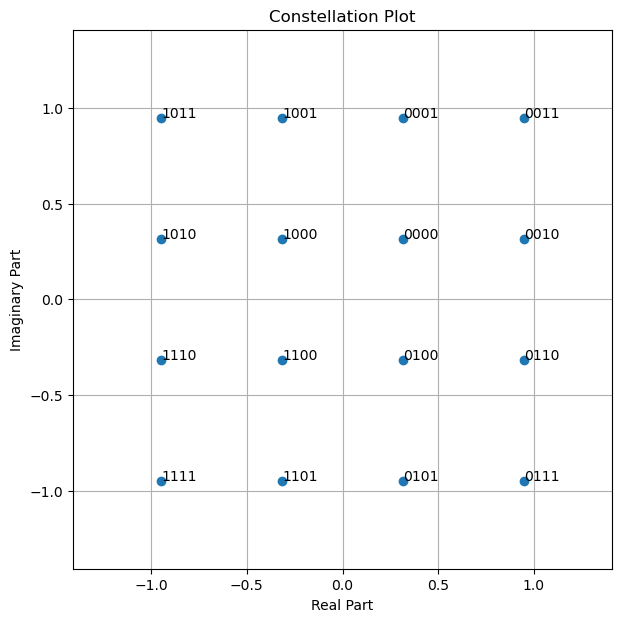

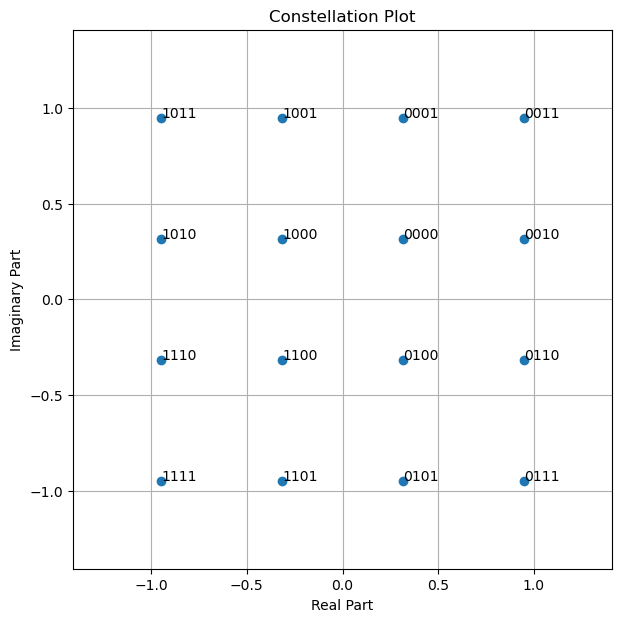

In [58]:
show(points, NUM_BITS_PER_SYMBOL)

In [59]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [60]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [61]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [9]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [62]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [63]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [64]:
onesample = dataset[0]

In [65]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [66]:
onesample['samples'].shape

torch.Size([64, 256])

In [67]:
onesample['labels'].shape

(64, 1024)

In [68]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [69]:
onebatch = next(iter(val_loader))

In [70]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [71]:
onebatch = next(iter(train_loader))

In [20]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [72]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [73]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(
            in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2 = nn.Linear(
            in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs  # [64, 64, 512]

        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0)  # [2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0)  # [64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z)  # [64, 64, 512, num_bits_per_symbol]
        # combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        z = z.flatten(-2, -1)
        return z

In [74]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [75]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [76]:
output.shape

torch.Size([32, 64, 1024])

In [77]:
output.dtype

torch.float32

In [78]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [79]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [80]:
loss_fn(test,test)

tensor(0.)

In [81]:
onebatch['labels'].dtype

torch.float32

In [82]:
loss_fn(output,onebatch['labels'])

tensor(0.7270, grad_fn=<BinaryCrossEntropyBackward0>)

In [83]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [84]:
train_losses = []
val_losses = []
val_BERs = []

In [85]:
model=model.to(device)

In [86]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|██████████| 640/640 [00:03<00:00, 183.40it/s]


Epoch [1/20], Loss: 0.6596, Val Loss: 0.6093, Val BER: 0.2650


100%|██████████| 640/640 [00:02<00:00, 228.79it/s]


Epoch [2/20], Loss: 0.6196, Val Loss: 0.6606, Val BER: 0.2554


100%|██████████| 640/640 [00:02<00:00, 230.17it/s]


Epoch [3/20], Loss: 0.6078, Val Loss: 0.5374, Val BER: 0.2495


100%|██████████| 640/640 [00:02<00:00, 228.09it/s]


Epoch [4/20], Loss: 0.6014, Val Loss: 0.5223, Val BER: 0.2390


100%|██████████| 640/640 [00:02<00:00, 230.27it/s]


Epoch [5/20], Loss: 0.5969, Val Loss: 0.5108, Val BER: 0.2363


100%|██████████| 640/640 [00:02<00:00, 230.07it/s]


Epoch [6/20], Loss: 0.5930, Val Loss: 0.8434, Val BER: 0.2321


100%|██████████| 640/640 [00:02<00:00, 230.30it/s]


Epoch [7/20], Loss: 0.5895, Val Loss: 0.8008, Val BER: 0.2249


100%|██████████| 640/640 [00:02<00:00, 229.03it/s]


Epoch [8/20], Loss: 0.5860, Val Loss: 0.5156, Val BER: 0.2202


100%|██████████| 640/640 [00:02<00:00, 230.42it/s]


Epoch [9/20], Loss: 0.5827, Val Loss: 0.9816, Val BER: 0.2174


100%|██████████| 640/640 [00:02<00:00, 228.79it/s]


Epoch [10/20], Loss: 0.5794, Val Loss: 0.4820, Val BER: 0.2171


100%|██████████| 640/640 [00:02<00:00, 229.38it/s]


Epoch [11/20], Loss: 0.5760, Val Loss: 0.4851, Val BER: 0.2076


100%|██████████| 640/640 [00:02<00:00, 228.28it/s]


Epoch [12/20], Loss: 0.5728, Val Loss: 0.5035, Val BER: 0.2072


100%|██████████| 640/640 [00:02<00:00, 231.33it/s]


Epoch [13/20], Loss: 0.5695, Val Loss: 0.4880, Val BER: 0.2043


100%|██████████| 640/640 [00:02<00:00, 229.54it/s]


Epoch [14/20], Loss: 0.5662, Val Loss: 0.5586, Val BER: 0.2017


100%|██████████| 640/640 [00:03<00:00, 201.88it/s]


Epoch [15/20], Loss: 0.5630, Val Loss: 0.8973, Val BER: 0.1976


100%|██████████| 640/640 [00:03<00:00, 202.99it/s]


Epoch [16/20], Loss: 0.5597, Val Loss: 0.7884, Val BER: 0.1982


100%|██████████| 640/640 [00:02<00:00, 228.87it/s]


Epoch [17/20], Loss: 0.5563, Val Loss: 0.4859, Val BER: 0.1947


100%|██████████| 640/640 [00:02<00:00, 229.30it/s]


Epoch [18/20], Loss: 0.5530, Val Loss: 0.4441, Val BER: 0.1936


100%|██████████| 640/640 [00:02<00:00, 231.46it/s]


Epoch [19/20], Loss: 0.5497, Val Loss: 0.4650, Val BER: 0.1944


100%|██████████| 640/640 [00:02<00:00, 228.44it/s]

Epoch [20/20], Loss: 0.5464, Val Loss: 0.4269, Val BER: 0.1906


In [87]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

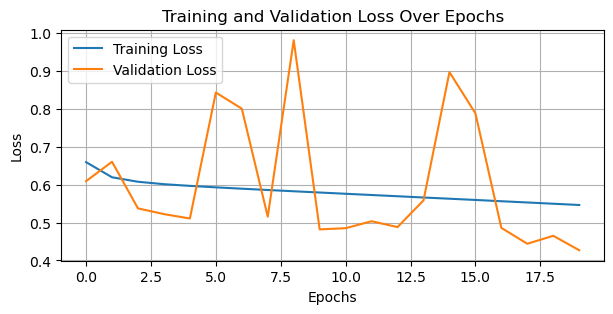

In [88]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

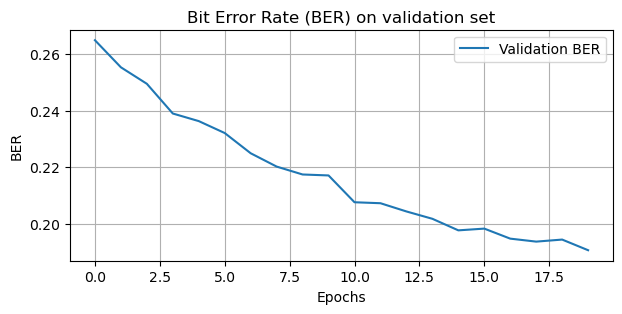

In [89]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [90]:

class ImprovedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(ImprovedModel, self).__init__()
        scale = 8
        self.layer1 = nn.Linear(in_features=2, out_features=scale*scale*num_bits_per_symbol)
        self.layer2 = nn.Linear(in_features=scale*scale*num_bits_per_symbol, out_features=scale*num_bits_per_symbol)
        self.layer3 = nn.Linear(
            in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)  # Update input size to 128
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.layer1(z)
        z = self.activation(z)
        z = self.layer2(z)
        z = self.activation(z)
        z = self.layer3(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [91]:
train_losses = []
val_losses = []
val_BERs = []
model = ImprovedModel(
num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
model = model.to(device)

num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()



    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    BER_batch = []

    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean = np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

100%|██████████| 640/640 [00:04<00:00, 155.59it/s]


Epoch [1/20], Loss: 0.5819, Val Loss: 0.7509, Val BER: 0.1775


100%|██████████| 640/640 [00:03<00:00, 174.37it/s]


Epoch [2/20], Loss: 0.4772, Val Loss: 0.4954, Val BER: 0.1730


100%|██████████| 640/640 [00:03<00:00, 168.55it/s]


Epoch [3/20], Loss: 0.4407, Val Loss: 0.1555, Val BER: 0.1728


100%|██████████| 640/640 [00:03<00:00, 167.39it/s]


Epoch [4/20], Loss: 0.4305, Val Loss: 0.6674, Val BER: 0.1728


100%|██████████| 640/640 [00:03<00:00, 174.08it/s]


Epoch [5/20], Loss: 0.4266, Val Loss: 0.7929, Val BER: 0.1729


100%|██████████| 640/640 [00:03<00:00, 173.81it/s]


Epoch [6/20], Loss: 0.4245, Val Loss: 0.7197, Val BER: 0.1733


100%|██████████| 640/640 [00:03<00:00, 180.07it/s]


Epoch [7/20], Loss: 0.4231, Val Loss: 0.1170, Val BER: 0.1729


100%|██████████| 640/640 [00:04<00:00, 149.76it/s]


Epoch [8/20], Loss: 0.4220, Val Loss: 0.2447, Val BER: 0.1732


100%|██████████| 640/640 [00:03<00:00, 168.98it/s]


Epoch [9/20], Loss: 0.4214, Val Loss: 0.7254, Val BER: 0.1730


100%|██████████| 640/640 [00:03<00:00, 169.83it/s]


Epoch [10/20], Loss: 0.4211, Val Loss: 0.7514, Val BER: 0.1727


100%|██████████| 640/640 [00:03<00:00, 167.72it/s]


Epoch [11/20], Loss: 0.4200, Val Loss: 0.4679, Val BER: 0.1729


100%|██████████| 640/640 [00:03<00:00, 176.58it/s]


Epoch [12/20], Loss: 0.4198, Val Loss: 0.0929, Val BER: 0.1728


100%|██████████| 640/640 [00:04<00:00, 148.68it/s]


Epoch [13/20], Loss: 0.4194, Val Loss: 0.1033, Val BER: 0.1727


100%|██████████| 640/640 [00:03<00:00, 176.69it/s]


Epoch [14/20], Loss: 0.4190, Val Loss: 0.8010, Val BER: 0.1727


100%|██████████| 640/640 [00:03<00:00, 179.36it/s]


Epoch [15/20], Loss: 0.4186, Val Loss: 0.0810, Val BER: 0.1727


100%|██████████| 640/640 [00:03<00:00, 173.51it/s]


Epoch [16/20], Loss: 0.4185, Val Loss: 0.5779, Val BER: 0.1726


100%|██████████| 640/640 [00:03<00:00, 176.04it/s]


Epoch [17/20], Loss: 0.4179, Val Loss: 0.0886, Val BER: 0.1728


100%|██████████| 640/640 [00:03<00:00, 174.99it/s]


Epoch [18/20], Loss: 0.4176, Val Loss: 0.7808, Val BER: 0.1726


100%|██████████| 640/640 [00:03<00:00, 174.91it/s]


Epoch [19/20], Loss: 0.4173, Val Loss: 0.2715, Val BER: 0.1727


100%|██████████| 640/640 [00:03<00:00, 175.87it/s]

Epoch [20/20], Loss: 0.4171, Val Loss: 0.6253, Val BER: 0.1728


In [92]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

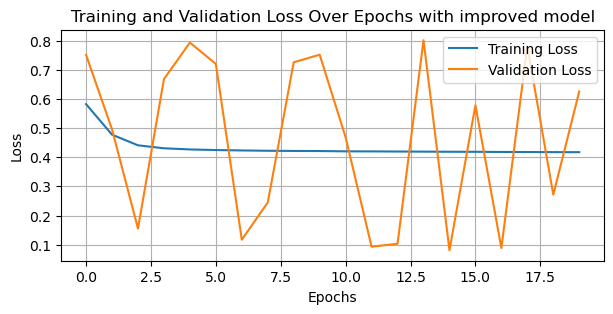

In [93]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs with improved model')
plt.grid(True)

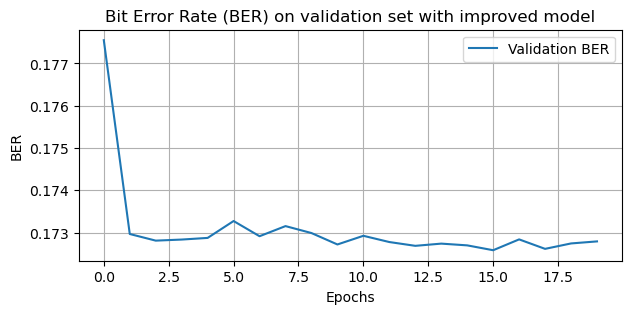

In [94]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set with improved model')
plt.grid(True)

In [95]:
for snr_db in [-10, 0, 10]:
    train_losses = []
    val_losses = []
    val_BERs = []
    # Modify dataset new snr_db
    dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE,
                             Blocklength=Blocklength, DB_MIN=snr_db-20, DB_MAX=snr_db+20, totaldbs=BATCH_SIZE*100)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_size, val_size])

    train_loader = DataLoader(
        dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(dataset=val_set, batch_size=1,
                            shuffle=True, pin_memory=True)

    model = ImprovedModel(
        num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
    model = model.to(device)

    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10

    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()

        for index, data_batch in enumerate(tqdm(train_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        BER_batch = []

        with torch.no_grad():
            for index, data_batch in enumerate(tqdm(val_loader)):
                batch = {k: v.to(device) for k, v in data_batch.items()}
                samples = batch['samples']
                labels = batch['labels']
                val_outputs = model(samples)
                val_loss = loss_fn(val_outputs, labels)

                binary_predictions = torch.round(val_outputs)
                error_count = torch.sum(binary_predictions != labels).float()
                error_rate = error_count / len(labels.flatten())
                BER_batch.append(error_rate.item())

        train_losses.append(average_loss)
        val_losses.append(val_loss.item())
        BER_batch_mean = np.mean(BER_batch)
        val_BERs.append(BER_batch_mean)

        print(
            f"SNR: {snr_db}, Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

(16,)


100%|██████████| 640/640 [00:03<00:00, 169.03it/s]


SNR: -10, Epoch [1/10], Loss: 0.6456, Val Loss: 0.7184, Val BER: 0.3224


100%|██████████| 640/640 [00:03<00:00, 161.08it/s]


SNR: -10, Epoch [2/10], Loss: 0.5967, Val Loss: 0.7221, Val BER: 0.3052


100%|██████████| 640/640 [00:03<00:00, 176.69it/s]


SNR: -10, Epoch [3/10], Loss: 0.5807, Val Loss: 0.7282, Val BER: 0.3037


100%|██████████| 640/640 [00:03<00:00, 180.95it/s]


SNR: -10, Epoch [4/10], Loss: 0.5739, Val Loss: 0.7126, Val BER: 0.3024


100%|██████████| 640/640 [00:04<00:00, 144.18it/s]


SNR: -10, Epoch [5/10], Loss: 0.5699, Val Loss: 0.6589, Val BER: 0.3027


100%|██████████| 640/640 [00:03<00:00, 184.05it/s]


SNR: -10, Epoch [6/10], Loss: 0.5679, Val Loss: 0.7395, Val BER: 0.3033


100%|██████████| 640/640 [00:03<00:00, 185.10it/s]


SNR: -10, Epoch [7/10], Loss: 0.5670, Val Loss: 0.7208, Val BER: 0.3020


100%|██████████| 640/640 [00:03<00:00, 183.25it/s]


SNR: -10, Epoch [8/10], Loss: 0.5665, Val Loss: 0.7185, Val BER: 0.3024


100%|██████████| 640/640 [00:03<00:00, 181.34it/s]


SNR: -10, Epoch [9/10], Loss: 0.5664, Val Loss: 0.7039, Val BER: 0.3018


100%|██████████| 640/640 [00:03<00:00, 180.95it/s]


SNR: -10, Epoch [10/10], Loss: 0.5657, Val Loss: 0.7024, Val BER: 0.3022
(16,)


100%|██████████| 640/640 [00:03<00:00, 169.29it/s]


SNR: 0, Epoch [1/10], Loss: 0.5825, Val Loss: 0.3760, Val BER: 0.1919


100%|██████████| 640/640 [00:03<00:00, 180.73it/s]


SNR: 0, Epoch [2/10], Loss: 0.4785, Val Loss: 0.7426, Val BER: 0.1892


100%|██████████| 640/640 [00:03<00:00, 177.88it/s]


SNR: 0, Epoch [3/10], Loss: 0.4393, Val Loss: 0.7545, Val BER: 0.1889


100%|██████████| 640/640 [00:03<00:00, 168.84it/s]


SNR: 0, Epoch [4/10], Loss: 0.4268, Val Loss: 0.3324, Val BER: 0.1891


100%|██████████| 640/640 [00:03<00:00, 161.99it/s]


SNR: 0, Epoch [5/10], Loss: 0.4221, Val Loss: 0.1647, Val BER: 0.1892


100%|██████████| 640/640 [00:03<00:00, 165.42it/s]


SNR: 0, Epoch [6/10], Loss: 0.4195, Val Loss: 0.1026, Val BER: 0.1893


100%|██████████| 640/640 [00:03<00:00, 171.85it/s]


SNR: 0, Epoch [7/10], Loss: 0.4180, Val Loss: 0.1439, Val BER: 0.1889


100%|██████████| 640/640 [00:04<00:00, 158.90it/s]


SNR: 0, Epoch [8/10], Loss: 0.4171, Val Loss: 0.1127, Val BER: 0.1890


100%|██████████| 640/640 [00:03<00:00, 173.93it/s]


SNR: 0, Epoch [9/10], Loss: 0.4161, Val Loss: 0.1076, Val BER: 0.1888


100%|██████████| 640/640 [00:03<00:00, 172.65it/s]


SNR: 0, Epoch [10/10], Loss: 0.4158, Val Loss: 0.1543, Val BER: 0.1888
(16,)


100%|██████████| 640/640 [00:04<00:00, 157.45it/s]


SNR: 10, Epoch [1/10], Loss: 0.4688, Val Loss: 0.2160, Val BER: 0.0704


100%|██████████| 640/640 [00:03<00:00, 173.13it/s]


SNR: 10, Epoch [2/10], Loss: 0.2930, Val Loss: 0.1081, Val BER: 0.0703


100%|██████████| 640/640 [00:03<00:00, 171.05it/s]


SNR: 10, Epoch [3/10], Loss: 0.2734, Val Loss: 0.0921, Val BER: 0.0701


100%|██████████| 640/640 [00:03<00:00, 167.66it/s]


SNR: 10, Epoch [4/10], Loss: 0.2632, Val Loss: 0.4472, Val BER: 0.0701


100%|██████████| 640/640 [00:03<00:00, 163.61it/s]


SNR: 10, Epoch [5/10], Loss: 0.2541, Val Loss: 0.0761, Val BER: 0.0702


100%|██████████| 640/640 [00:03<00:00, 160.06it/s]


SNR: 10, Epoch [6/10], Loss: 0.2469, Val Loss: 0.0702, Val BER: 0.0703


100%|██████████| 640/640 [00:03<00:00, 171.74it/s]


SNR: 10, Epoch [7/10], Loss: 0.2419, Val Loss: 0.3382, Val BER: 0.0705


100%|██████████| 640/640 [00:03<00:00, 161.06it/s]


SNR: 10, Epoch [8/10], Loss: 0.2389, Val Loss: 0.0518, Val BER: 0.0704


100%|██████████| 640/640 [00:03<00:00, 174.18it/s]


SNR: 10, Epoch [9/10], Loss: 0.2371, Val Loss: 0.0461, Val BER: 0.0704


100%|██████████| 640/640 [00:03<00:00, 172.40it/s]

SNR: 10, Epoch [10/10], Loss: 0.2358, Val Loss: 0.0477, Val BER: 0.0706


In [96]:
train_losses = []
val_losses = []
val_BERs = []

dataset = ComplexDataset(num_bits_per_symbol=2, Frame_SIZE=Frame_SIZE,
                        Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(
    dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1,
                        shuffle=True, pin_memory=True)


model = ImprovedModel(
    num_bits_per_symbol=2, H=Frame_SIZE, W=Blocklength)
model = model.to(device)

num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    total_loss = 0.0
    model.train()

    accumulation_steps = 4  # Accumulate gradients over 4 batches before optimizing, ram ran out of memory

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()
        outputs = model(samples)
        loss = loss_fn(outputs, labels)
        loss.backward()

        if (index + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item()

    # Validation
    model.eval()
    BER_batch = []

    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            # Adjust the target labels to match the model output size
            # Assuming the correct size is 512
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            binary_predictions = torch.round(val_outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            BER_batch.append(error_rate.item())

    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean = np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)

    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

(4,)


100%|██████████| 640/640 [00:05<00:00, 123.48it/s]


Epoch [1/10], Loss: 0.2358, Val Loss: 0.7602, Val BER: 0.1596


100%|██████████| 640/640 [00:04<00:00, 139.79it/s]


Epoch [2/10], Loss: 0.2358, Val Loss: 0.7101, Val BER: 0.1533


100%|██████████| 640/640 [00:04<00:00, 141.09it/s]


Epoch [3/10], Loss: 0.2358, Val Loss: 0.4154, Val BER: 0.1533


100%|██████████| 640/640 [00:04<00:00, 139.89it/s]


Epoch [4/10], Loss: 0.2358, Val Loss: 0.3663, Val BER: 0.1537


100%|██████████| 640/640 [00:04<00:00, 139.41it/s]


Epoch [5/10], Loss: 0.2358, Val Loss: 0.8852, Val BER: 0.1538


100%|██████████| 640/640 [00:04<00:00, 139.69it/s]


Epoch [6/10], Loss: 0.2358, Val Loss: 0.6758, Val BER: 0.1537


100%|██████████| 640/640 [00:04<00:00, 134.15it/s]


Epoch [7/10], Loss: 0.2358, Val Loss: 0.8572, Val BER: 0.1538


100%|██████████| 640/640 [00:04<00:00, 140.91it/s]


Epoch [8/10], Loss: 0.2358, Val Loss: 0.3783, Val BER: 0.1537


100%|██████████| 640/640 [00:04<00:00, 138.51it/s]


Epoch [9/10], Loss: 0.2358, Val Loss: 0.2206, Val BER: 0.1538


100%|██████████| 640/640 [00:04<00:00, 139.35it/s]

Epoch [10/10], Loss: 0.2358, Val Loss: 0.7935, Val BER: 0.1537


In [97]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

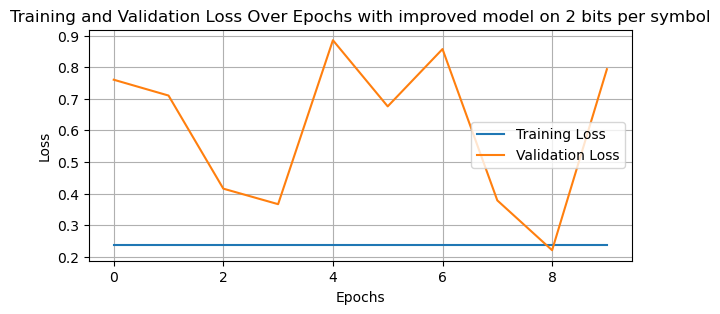

In [98]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs with improved model on 2 bits per symbol')
plt.grid(True)

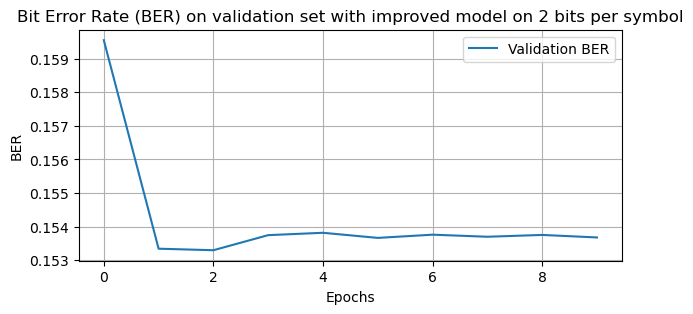

In [99]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set with improved model on 2 bits per symbol')
plt.grid(True)

In [49]:

for snr_db in [-10, 0, 10]:
    train_losses = []
    val_losses = []
    val_BERs = []
    # Modify dataset new db
    dataset = ComplexDataset(num_bits_per_symbol=2, Frame_SIZE=Frame_SIZE,
                             Blocklength=Blocklength, DB_MIN=snr_db-20, DB_MAX=snr_db+20, totaldbs=BATCH_SIZE*100)
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(
        dataset, [train_size, val_size])

    train_loader = DataLoader(
        dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    val_loader = DataLoader(dataset=val_set, batch_size=1,
                            shuffle=True, pin_memory=True)

    
    
    
    model = ImprovedModel(
        num_bits_per_symbol=2, H=Frame_SIZE, W=Blocklength)
    model = model.to(device)  
    
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10 

    for epoch in range(num_epochs):
        total_loss = 0.0
        model.train()

        for index, data_batch in enumerate(tqdm(train_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            optimizer.zero_grad()
            outputs = model(samples)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        BER_batch = []

        with torch.no_grad():
            for index, data_batch in enumerate(tqdm(val_loader)):
                batch = {k: v.to(device) for k, v in data_batch.items()}
                samples = batch['samples']
                labels = batch['labels']
                val_outputs = model(samples)
                val_loss = loss_fn(val_outputs, labels)

                binary_predictions = torch.round(val_outputs)
                error_count = torch.sum(binary_predictions != labels).float()
                error_rate = error_count / len(labels.flatten())
                BER_batch.append(error_rate.item())

        train_losses.append(average_loss)
        val_losses.append(val_loss.item())
        BER_batch_mean = np.mean(BER_batch)
        val_BERs.append(BER_batch_mean)

        print(
            f"SNR: {snr_db}, Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")

(4,)


100%|██████████| 640/640 [00:03<00:00, 164.24it/s]


SNR: -10, Epoch [1/10], Loss: 0.6732, Val Loss: 0.6342, Val BER: 0.2770


100%|██████████| 640/640 [00:03<00:00, 175.78it/s]


SNR: -10, Epoch [2/10], Loss: 0.6320, Val Loss: 0.7004, Val BER: 0.2747


100%|██████████| 640/640 [00:03<00:00, 175.51it/s]


SNR: -10, Epoch [3/10], Loss: 0.5849, Val Loss: 0.4690, Val BER: 0.2701


100%|██████████| 640/640 [00:03<00:00, 176.64it/s]


SNR: -10, Epoch [4/10], Loss: 0.5580, Val Loss: 0.2925, Val BER: 0.2702


100%|██████████| 640/640 [00:03<00:00, 176.64it/s]


SNR: -10, Epoch [5/10], Loss: 0.5449, Val Loss: 0.2408, Val BER: 0.2701


100%|██████████| 640/640 [00:03<00:00, 177.00it/s]


SNR: -10, Epoch [6/10], Loss: 0.5370, Val Loss: 0.1905, Val BER: 0.2689


100%|██████████| 640/640 [00:03<00:00, 173.10it/s]


SNR: -10, Epoch [7/10], Loss: 0.5316, Val Loss: 0.7228, Val BER: 0.2679


100%|██████████| 640/640 [00:03<00:00, 173.03it/s]


SNR: -10, Epoch [8/10], Loss: 0.5283, Val Loss: 0.7289, Val BER: 0.2681


100%|██████████| 640/640 [00:03<00:00, 175.20it/s]


SNR: -10, Epoch [9/10], Loss: 0.5265, Val Loss: 0.7057, Val BER: 0.2674


100%|██████████| 640/640 [00:03<00:00, 174.52it/s]


SNR: -10, Epoch [10/10], Loss: 0.5253, Val Loss: 0.3558, Val BER: 0.2676
(4,)


100%|██████████| 640/640 [00:03<00:00, 171.83it/s]


SNR: 0, Epoch [1/10], Loss: 0.6395, Val Loss: 0.4960, Val BER: 0.1655


100%|██████████| 640/640 [00:03<00:00, 175.89it/s]


SNR: 0, Epoch [2/10], Loss: 0.5329, Val Loss: 0.6839, Val BER: 0.1634


100%|██████████| 640/640 [00:03<00:00, 168.19it/s]


SNR: 0, Epoch [3/10], Loss: 0.4603, Val Loss: 0.8605, Val BER: 0.1635


100%|██████████| 640/640 [00:03<00:00, 173.82it/s]


SNR: 0, Epoch [4/10], Loss: 0.4051, Val Loss: 0.1467, Val BER: 0.1652


100%|██████████| 640/640 [00:03<00:00, 177.40it/s]


SNR: 0, Epoch [5/10], Loss: 0.3808, Val Loss: 0.5070, Val BER: 0.1657


100%|██████████| 640/640 [00:03<00:00, 171.53it/s]


SNR: 0, Epoch [6/10], Loss: 0.3715, Val Loss: 0.6914, Val BER: 0.1651


100%|██████████| 640/640 [00:03<00:00, 177.74it/s]


SNR: 0, Epoch [7/10], Loss: 0.3656, Val Loss: 0.4355, Val BER: 0.1649


100%|██████████| 640/640 [00:03<00:00, 178.03it/s]


SNR: 0, Epoch [8/10], Loss: 0.3617, Val Loss: 0.0777, Val BER: 0.1643


100%|██████████| 640/640 [00:03<00:00, 172.30it/s]


SNR: 0, Epoch [9/10], Loss: 0.3592, Val Loss: 0.0985, Val BER: 0.1641


100%|██████████| 640/640 [00:03<00:00, 175.55it/s]


SNR: 0, Epoch [10/10], Loss: 0.3574, Val Loss: 0.0587, Val BER: 0.1642
(4,)


100%|██████████| 640/640 [00:03<00:00, 171.77it/s]


SNR: 10, Epoch [1/10], Loss: 0.5894, Val Loss: 0.4103, Val BER: 0.0573


100%|██████████| 640/640 [00:03<00:00, 177.03it/s]


SNR: 10, Epoch [2/10], Loss: 0.3122, Val Loss: 0.1127, Val BER: 0.0557


100%|██████████| 640/640 [00:03<00:00, 174.43it/s]


SNR: 10, Epoch [3/10], Loss: 0.2114, Val Loss: 0.0527, Val BER: 0.0555


100%|██████████| 640/640 [00:03<00:00, 176.87it/s]


SNR: 10, Epoch [4/10], Loss: 0.2016, Val Loss: 0.0432, Val BER: 0.0555


100%|██████████| 640/640 [00:03<00:00, 171.75it/s]


SNR: 10, Epoch [5/10], Loss: 0.1988, Val Loss: 0.5769, Val BER: 0.0554


100%|██████████| 640/640 [00:03<00:00, 173.34it/s]


SNR: 10, Epoch [6/10], Loss: 0.1960, Val Loss: 0.0788, Val BER: 0.0554


100%|██████████| 640/640 [00:03<00:00, 175.37it/s]


SNR: 10, Epoch [7/10], Loss: 0.1931, Val Loss: 0.4016, Val BER: 0.0555


100%|██████████| 640/640 [00:03<00:00, 179.01it/s]


SNR: 10, Epoch [8/10], Loss: 0.1901, Val Loss: 0.0471, Val BER: 0.0554


100%|██████████| 640/640 [00:03<00:00, 174.07it/s]


SNR: 10, Epoch [9/10], Loss: 0.1869, Val Loss: 0.0612, Val BER: 0.0555


100%|██████████| 640/640 [00:03<00:00, 179.02it/s]

SNR: 10, Epoch [10/10], Loss: 0.1837, Val Loss: 0.0307, Val BER: 0.0555
